# Prompt Based Harmful Message detection using MCP and LLM

https://docs.gpt4all.io/gpt4all_desktop/models.html#explore-models

https://github.com/deepseek-ai/DeepSeek-R1

In [1]:
!pip install datasets pandas scikit-learn matplotlib seaborn openai tqdm

In [2]:
!pip install --upgrade datasets

In [3]:
!pip install gpt4all

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import time
from datetime import datetime
from tqdm import tqdm
from openai import OpenAI
from dotenv import load_dotenv
try:
    from gpt4all import GPT4All
except ImportError:
    GPT4All = None
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

tqdm.pandas()
load_dotenv()

True

# Test - Debugging

In [5]:
# Model configuration
MODEL_TYPE = "deepseek"  # Options: "deepseek", "gpt4all", "mistral"
DEEPSEEK_MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
GPT4ALL_MODEL = "Meta-Llama-3-8B-Instruct.Q4_0.gguf"
GPT4ALL_MODEL_PATH = "/home/sagemaker-user/harmfull-detection/models/"
MISTRAL_MODEL = "/tmp/models/mistral-7b-v0-2"
# Initialize clients
if MODEL_TYPE == "deepseek":
    client = OpenAI(
        api_key=os.getenv("DEEPSEEK_API_KEY"),
        base_url="http://k8s-deepseek-deepseek-e92cca8149-b20547a64509f06f.elb.eu-west-1.amazonaws.com/v1"
    )
elif MODEL_TYPE == "mistral":
    client = OpenAI(
        api_key=os.getenv("MISTRAL_API_KEY"),
        base_url="http://vllm-serve-svc-pub-288545519.us-west-2.elb.amazonaws.com/v1"
    )    
elif MODEL_TYPE == "gpt4all":
    if GPT4All is None:
        raise ImportError("Install gpt4all: pip install gpt4all")
    
    model_file = os.path.join(GPT4ALL_MODEL_PATH, GPT4ALL_MODEL)
    if os.path.exists(model_file):
        print(f"Loading cached model from {model_file}")
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH, allow_download=False)
    else:
        print(f"Downloading model to {GPT4ALL_MODEL_PATH}")
        os.makedirs(GPT4ALL_MODEL_PATH, exist_ok=True)
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH)

def predict_with_model(text):
    prompt = f'Analyze this message and respond ONLY with JSON: {{"action": "allow|warn|block|timeout", "confidence": 0.0-1.0, "categories": ["list of violation types]}}: "{text}"'
    
    try:
        if MODEL_TYPE == "deepseek":
            response = client.chat.completions.create(
                model=DEEPSEEK_MODEL,
                messages=[
                    {"role": "system", "content": "You are a content moderation assistant. Respond only with JSON."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            reply = response.choices[0].message.content.strip()
        
        elif MODEL_TYPE == "gpt4all":
            with client.chat_session():
                reply = client.generate(prompt, max_tokens=1024)
                
        print("Model output:", reply)  # Add before json_match
        
        json_match = re.search(r'\{.*\}', reply, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
            return 1 if result.get("action", "").upper() == "BLOCK" else 0
        return 0
    except:
        return 0

def measure_inference_times(texts, predict_fn):
    times, predictions = [], []
    for text in tqdm(texts, desc="Processing texts"):
        start = time.time()
        pred = predict_fn(text)
        times.append(time.time() - start)
        predictions.append(pred)
    return predictions, times

def generate_performance_report(y_true, y_pred, inference_times=None):
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred))
    
    if inference_times:
        times_ms = np.array(inference_times) * 1000
        print(f"\n⏱️ Mean inference time: {np.mean(times_ms):.2f}ms")

print("Model configuration completed")

Model configuration completed


In [6]:
# Test the function
test_text = "You are a terrible person!"
result = predict_with_model(test_text)
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")


Model output: Okay, so I need to analyze this message: "You are a terrible person!" and decide whether to allow, warn, block, or timeout the user, along with the confidence level and the category of violation. 

First, I should consider what the message is saying. The user is calling someone a terrible person. That's a strong, derogatory term. It's clearly offensive and intended to insult the recipient. Such language can be hurtful and violate community guidelines that promote respect and kindness.

Next, I should think about the context. Without knowing the specific situation, I can assume that using such harsh language is not appropriate. It's likely intended to attack or demean someone, which is against most content policies.

Now, considering the categories, this definitely falls under "abusive or harassing" behavior. It's a personal attack that can harm others. The confidence level should be high because the message is clearly offensive and not ambiguous.

So, the action should be

# Model configuration - DeepSeek R1-Distill-Llama-8B

In [7]:
# Model configuration
MODEL_TYPE = "deepseek"  # Options: "deepseek", "gpt4all", "mistral"
DEEPSEEK_MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
GPT4ALL_MODEL = "Meta-Llama-3-8B-Instruct.Q4_0.gguf"
GPT4ALL_MODEL_PATH = "/home/sagemaker-user/harmfull-detection/models/"
MISTRAL_MODEL = "/tmp/models/mistral-7b-v0-2"
# Initialize clients
if MODEL_TYPE == "deepseek":
    client = OpenAI(
        api_key=os.getenv("DEEPSEEK_API_KEY"),
        base_url="http://k8s-deepseek-deepseek-e92cca8149-b20547a64509f06f.elb.eu-west-1.amazonaws.com/v1"
    )
elif MODEL_TYPE == "mistral":
    client = OpenAI(
        api_key=os.getenv("MISTRAL_API_KEY"),
        base_url="http://vllm-serve-svc-pub-288545519.us-west-2.elb.amazonaws.com/v1"
    )    
elif MODEL_TYPE == "gpt4all":
    if GPT4All is None:
        raise ImportError("Install gpt4all: pip install gpt4all")
    
    model_file = os.path.join(GPT4ALL_MODEL_PATH, GPT4ALL_MODEL)
    if os.path.exists(model_file):
        print(f"Loading cached model from {model_file}")
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH, allow_download=False)
    else:
        print(f"Downloading model to {GPT4ALL_MODEL_PATH}")
        os.makedirs(GPT4ALL_MODEL_PATH, exist_ok=True)
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH)

def predict_with_model(text):
    prompt = f'Analyze this message and respond ONLY with JSON: {{"action": "allow|warn|block|timeout", "confidence": 0.0-1.0, "categories": ["list of violation types"]}}: "{text}"'
    
    try:
        if MODEL_TYPE == "deepseek":
            response = client.chat.completions.create(
                model=DEEPSEEK_MODEL,
                messages=[
                    {"role": "system", "content": "You are a content moderation assistant. Respond only with JSON."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            reply = response.choices[0].message.content.strip()
        
        elif MODEL_TYPE == "gpt4all":
            with client.chat_session():
                reply = client.generate(prompt, max_tokens=1024)
        
        json_match = re.search(r'\{.*\}', reply, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
            return 1 if result.get("action", "").upper() == "BLOCK" else 0
        return 0
    except:
        return 0

def measure_inference_times(texts, predict_fn):
    times, predictions = [], []
    for text in tqdm(texts, desc="Processing texts"):
        start = time.time()
        pred = predict_fn(text)
        times.append(time.time() - start)
        predictions.append(pred)
    return predictions, times

def generate_performance_report(y_true, y_pred, inference_times=None):
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred))
    
    if inference_times:
        times_ms = np.array(inference_times) * 1000
        print(f"\n⏱️ Mean inference time: {np.mean(times_ms):.2f}ms")

print("Model configuration completed")

Model configuration completed


In [8]:
# Load and sample data
df_test = pd.read_csv("/home/sagemaker-user/test.csv")
n_samples = 20
sample_df = pd.concat([
    df_test[df_test["label"] == 1].sample(n=n_samples, random_state=42),
    df_test[df_test["label"] == 0].sample(n=n_samples, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset balanced: {sample_df['label'].value_counts().tolist()}")


Dataset balanced: [20, 20]


In [9]:
# Run predictions with timing
print(f"\n🚀 Running inference with {MODEL_TYPE}...")
predictions, inference_times = measure_inference_times(sample_df["text"], predict_with_model)


🚀 Running inference with deepseek...


Processing texts: 100%|██████████| 40/40 [07:13<00:00, 10.84s/it]



📊 Metrics:
Accuracy: 0.8000
Precision: 0.8750
Recall: 0.7000
F1: 0.7778
AUC: 0.8000

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        20
           1       0.88      0.70      0.78        20

    accuracy                           0.80        40
   macro avg       0.81      0.80      0.80        40
weighted avg       0.81      0.80      0.80        40


⏱️ Mean inference time: 10834.75ms


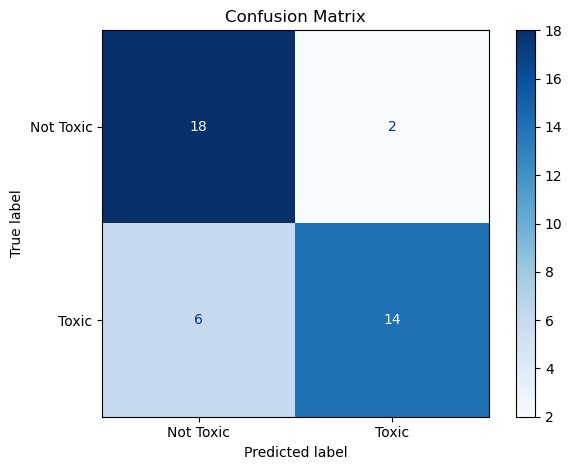

/tmp/ipykernel_24223/3815011085.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")


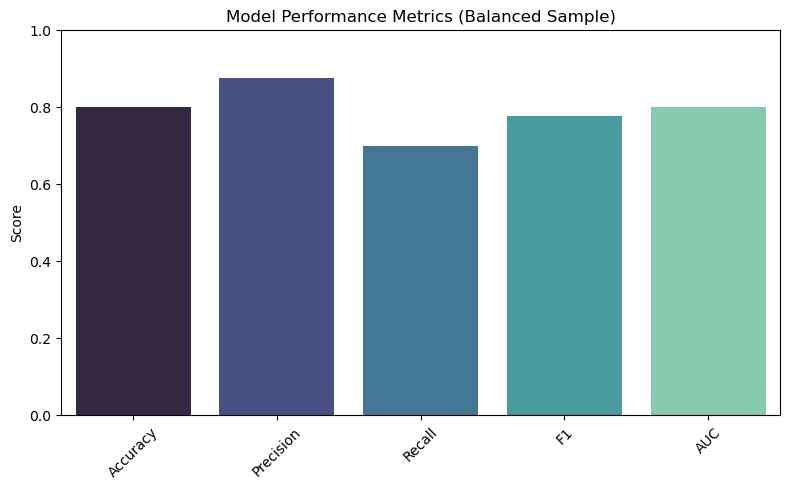


💾 Results saved to moderation_results_deepseek_20250812_072840.csv


In [10]:
# Evaluate
y_true, y_pred = sample_df["label"], predictions
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1": f1_score(y_true, y_pred),
    "AUC": roc_auc_score(y_true, y_pred)
}

print("\n📊 Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

generate_performance_report(y_true, y_pred, inference_times)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Toxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Bar Plot of Metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")
plt.title("Model Performance Metrics (Balanced Sample)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save results
results_df = pd.DataFrame({
    'text': sample_df["text"],
    'true_label': y_true,
    'predicted_label': y_pred,
    'inference_time_ms': np.array(inference_times) * 1000
})
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_df.to_csv(f'moderation_results_deepseek_{timestamp}.csv', index=False)
print(f"\n💾 Results saved to moderation_results_deepseek_{timestamp}.csv")    

# Model configuration - gpt4all Llama 3 

In [11]:
# Model configuration
MODEL_TYPE = "gpt4all"  # Options: "deepseek", "gpt4all", "mistral"
DEEPSEEK_MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
GPT4ALL_MODEL = "Meta-Llama-3-8B-Instruct.Q4_0.gguf"
GPT4ALL_MODEL_PATH = "/home/sagemaker-user/harmfull-detection/models/"
MISTRAL_MODEL = "/tmp/models/mistral-7b-v0-2"
# Initialize clients
if MODEL_TYPE == "deepseek":
    client = OpenAI(
        api_key=os.getenv("DEEPSEEK_API_KEY"),
        base_url="http://k8s-deepseek-deepseek-e92cca8149-b20547a64509f06f.elb.eu-west-1.amazonaws.com/v1"
    )
elif MODEL_TYPE == "mistral":
    client = OpenAI(
        api_key=os.getenv("MISTRAL_API_KEY"),
        base_url="http://vllm-serve-svc-pub-288545519.us-west-2.elb.amazonaws.com/v1"
    )    
elif MODEL_TYPE == "gpt4all":
    if GPT4All is None:
        raise ImportError("Install gpt4all: pip install gpt4all")
    
    model_file = os.path.join(GPT4ALL_MODEL_PATH, GPT4ALL_MODEL)
    if os.path.exists(model_file):
        print(f"Loading cached model from {model_file}")
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH, allow_download=False)
    else:
        print(f"Downloading model to {GPT4ALL_MODEL_PATH}")
        os.makedirs(GPT4ALL_MODEL_PATH, exist_ok=True)
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH)

def predict_with_model(text):
    prompt = f'Analyze this message and respond ONLY with JSON: {{"action": "allow|warn|block|timeout", "confidence": 0.0-1.0, "categories": ["list of violation types"]}}: "{text}"'
    
    try:
        if MODEL_TYPE == "deepseek":
            response = client.chat.completions.create(
                model=DEEPSEEK_MODEL,
                messages=[
                    {"role": "system", "content": "You are a content moderation assistant. Respond only with JSON."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            reply = response.choices[0].message.content.strip()
        
        elif MODEL_TYPE == "gpt4all":
            with client.chat_session():
                reply = client.generate(prompt, max_tokens=1024)
        
        json_match = re.search(r'\{.*\}', reply, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
            return 1 if result.get("action", "").upper() == "BLOCK" else 0
        return 0
    except:
        return 0

def measure_inference_times(texts, predict_fn):
    times, predictions = [], []
    for text in tqdm(texts, desc="Processing texts"):
        start = time.time()
        pred = predict_fn(text)
        times.append(time.time() - start)
        predictions.append(pred)
    return predictions, times

def generate_performance_report(y_true, y_pred, inference_times=None):
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred))
    
    if inference_times:
        times_ms = np.array(inference_times) * 1000
        print(f"\n⏱️ Mean inference time: {np.mean(times_ms):.2f}ms")

print("Model configuration completed")

Loading cached model from /home/sagemaker-user/harmfull-detection/models/Meta-Llama-3-8B-Instruct.Q4_0.gguf


Failed to load libllamamodel-mainline-cuda-avxonly.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory
Failed to load libllamamodel-mainline-cuda.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory


Model configuration completed


In [12]:
# Run predictions with timing
print(f"\n🚀 Running inference with {MODEL_TYPE}...")
predictions, inference_times = measure_inference_times(sample_df["text"], predict_with_model)


🚀 Running inference with gpt4all...


Processing texts: 100%|██████████| 40/40 [35:50<00:00, 53.76s/it]



📊 Metrics:
Accuracy: 0.6250
Precision: 0.6923
Recall: 0.4500
F1: 0.5455
AUC: 0.6250

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.80      0.68        20
           1       0.69      0.45      0.55        20

    accuracy                           0.62        40
   macro avg       0.64      0.62      0.61        40
weighted avg       0.64      0.62      0.61        40


⏱️ Mean inference time: 53756.16ms


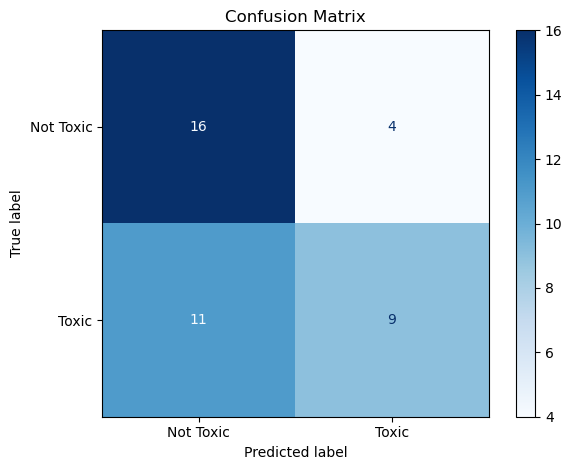

/tmp/ipykernel_24223/3542555518.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")


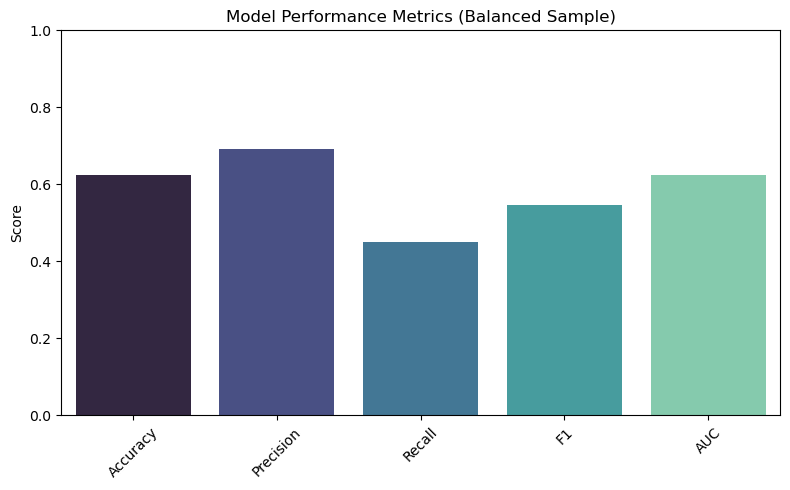


💾 Results saved to moderation_results_gpt4all_20250812_085149.csv


In [13]:
# Evaluate
y_true, y_pred = sample_df["label"], predictions
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1": f1_score(y_true, y_pred),
    "AUC": roc_auc_score(y_true, y_pred)
}

print("\n📊 Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

generate_performance_report(y_true, y_pred, inference_times)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Toxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Bar Plot of Metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")
plt.title("Model Performance Metrics (Balanced Sample)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save results
results_df = pd.DataFrame({
    'text': sample_df["text"],
    'true_label': y_true,
    'predicted_label': y_pred,
    'inference_time_ms': np.array(inference_times) * 1000
})
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_df.to_csv(f'moderation_results_gpt4all_{timestamp}.csv', index=False)
print(f"\n💾 Results saved to moderation_results_gpt4all_{timestamp}.csv")    

# Debugging

In [14]:
# Model configuration
MODEL_TYPE = "deepseek"  # Options: "deepseek", "gpt4all", "mistral"
DEEPSEEK_MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
GPT4ALL_MODEL = "Meta-Llama-3-8B-Instruct.Q4_0.gguf"
GPT4ALL_MODEL_PATH = "/home/sagemaker-user/harmfull-detection/models/"
MISTRAL_MODEL = "/tmp/models/mistral-7b-v0-2"
# Initialize clients
if MODEL_TYPE == "deepseek":
    client = OpenAI(
        api_key=os.getenv("DEEPSEEK_API_KEY"),
        base_url="http://k8s-deepseek-deepseek-e92cca8149-b20547a64509f06f.elb.eu-west-1.amazonaws.com/v1"
    )
elif MODEL_TYPE == "mistral":
    client = OpenAI(
        api_key=os.getenv("MISTRAL_API_KEY"),
        base_url="http://vllm-serve-svc-pub-288545519.us-west-2.elb.amazonaws.com/v1"
    )    
elif MODEL_TYPE == "gpt4all":
    if GPT4All is None:
        raise ImportError("Install gpt4all: pip install gpt4all")
    
    model_file = os.path.join(GPT4ALL_MODEL_PATH, GPT4ALL_MODEL)
    if os.path.exists(model_file):
        print(f"Loading cached model from {model_file}")
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH, allow_download=False)
    else:
        print(f"Downloading model to {GPT4ALL_MODEL_PATH}")
        os.makedirs(GPT4ALL_MODEL_PATH, exist_ok=True)
        client = GPT4All(model_name=GPT4ALL_MODEL, model_path=GPT4ALL_MODEL_PATH)

def predict_with_model(text):
    prompt = f'Analyze this message and respond ONLY with JSON: {{"action": "allow|warn|block|timeout", "confidence": 0.0-1.0, "categories": ["list of violation types]}}: "{text}"'
    
    try:
        if MODEL_TYPE == "deepseek":
            response = client.chat.completions.create(
                model=DEEPSEEK_MODEL,
                messages=[
                    {"role": "system", "content": "You are a content moderation assistant. Respond only with JSON."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            reply = response.choices[0].message.content.strip()
        
        elif MODEL_TYPE == "gpt4all":
            with client.chat_session():
                reply = client.generate(prompt, max_tokens=1024)
                
        print("Model output:", reply)  # Add before json_match
        
        json_match = re.search(r'\{.*\}', reply, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
            return 1 if result.get("action", "").upper() == "BLOCK" else 0
        return 0
    except:
        return 0

def measure_inference_times(texts, predict_fn):
    times, predictions = [], []
    for text in tqdm(texts, desc="Processing texts"):
        start = time.time()
        pred = predict_fn(text)
        times.append(time.time() - start)
        predictions.append(pred)
    return predictions, times

def generate_performance_report(y_true, y_pred, inference_times=None):
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred))
    
    if inference_times:
        times_ms = np.array(inference_times) * 1000
        print(f"\n⏱️ Mean inference time: {np.mean(times_ms):.2f}ms")

print("Model configuration completed")

Model configuration completed


In [15]:
# Test the function
test_text = "You are a terrible person!"
result = predict_with_model(test_text)
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")

Model output: Okay, so I need to analyze this message: "You are a terrible person!" and decide whether to allow, warn, block, or timeout the user, along with the confidence level and the category of violation. 

First, I should consider what the message is saying. The user is calling someone a "terrible person." That's a strong, derogatory term. It's clearly offensive and intended to insult the recipient. Such language can be hurtful and is likely to create a negative environment.

Next, I should think about the context. Without knowing the specific situation, I can assume that using such harsh language is inappropriate. It's a personal attack that goes beyond just expressing strong opinions. The term "terrible person" is a direct insult and can be considered hate speech or at least a form of abuse.

Now, considering the categories, this definitely falls under "abusive language" because it's meant to demean someone. It's not just a casual insult; it's more severe. The confidence level 

In [16]:
# Test the function
test_text = """
"The German government, apparently,  puts the number of German citizens killed in the terrible disruption after WWII at 2 to 2.5 million. Other estimates are lower . . . as much as 2/3's lower. Is it really your contention that they were all massacred by Jews? 

Did they teach you this pestiferous crap at Stanford? You should ask for your money back. !"
"""

result = predict_with_model(test_text)
# print(f"Ground Truth: 1 - toxic in original downloaded dataset. This will be corrected")
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")

Model output: Okay, so I need to analyze this message and decide whether to allow, warn, block, or timeout the user. The message is pretty harsh, calling the user an idiot and accusing them of spreading hate. The user is questioning the number of German civilians killed after WWII and links it to Jews, which is a sensitive and offensive topic. They also mention Stanford, implying the user is educated but is using that knowledge to spread harmful information. The tone is confrontational and uses derogatory language, which could escalate tensions. I should consider the categories like hate speech, anti-Semitism, and harassment. The confidence is high because the content is clearly offensive and harmful. So, the action should be block, confidence 1.0, and categories as hate speech, anti-Semitism, and harassment.
</think>

```json
{
  "action": "block",
  "confidence": 1.0,
  "categories": ["hate speech", "anti-Semitism", "harassment"]
}
```
Moderation result (1=toxic, 0=non-toxic): 1


In [17]:
# Test the function
test_text = """
"Political motivations, and parties aside. I would love to know peoples actual thoughts on this. Good. Bad? Could we actually get bipartisan support or is it a pipe dream. 

Additionally, the idea of a high speed transit in the windsor to toronto, and maybe in the future toronto to montreal corridors (which is like half of Canada's population) is one that may be interesting. There isn't much debate that infrastructure like this can massively foster growth along the route, but there is also the price factor. People don't like it in their backyard. 

Also, since this will be costly regardless, I would be curious price comparisons between HSR and Maglev. Mostly because the latter is more expensive but will require reduced maintenance costs whilst also having the advantage of being far quieter, likely reducing ""NIMBY"" BS. Not to mention it would be a great selling point of ""hey, look at our futuresque shit that travels at speeds that rival planes""."
"""
result = predict_with_model(test_text)
# print(f"Ground Truth: 1 - toxic in original downloaded dataset. This will be corrected")
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")

Model output: Alright, so I need to analyze this message and decide whether to allow, warn, block, or timeout the user. The message is about political motivations, infrastructure like high-speed rail and Maglev, and some economic aspects. 

First, I'll read through the message carefully. The user is discussing both political and infrastructure topics. They mention political motivations but then quickly clarify they want to know people's actual thoughts, not just party lines. That seems neutral.

Next, they talk about a high-speed transit project from Windsor to Toronto and possibly Toronto to Montreal. They note that infrastructure can foster growth but also mention the cost factor, which could be a concern for people. They compare HSR and Maglev, noting that Maglev is more expensive but has lower maintenance costs and is quieter, which might reduce NIMBY issues. They end with a positive note about future infrastructure.

I need to categorize this. The user is sharing their thoughts on

In [18]:
# Test the function
test_text = """
Merkel smart and progressive. Trump not in the least bit smart and utterly regressive. The US will be the unconditional loser as the world turns away, in everything from trade and tourism to science and collaboration. What an utter and avoidable waste. aMErica.
"""
result = predict_with_model(test_text)
# print(f"Ground Truth: 1 - toxic in original downloaded dataset. This will be corrected")
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")

Model output: Okay, so I need to analyze this message and decide whether to allow, warn, block, or timeout the user. The message says, "Merkel smart and progressive. Trump not in the least bit smart and utterly regressive. The US will be the unconditional loser as the world turns away, in everything from trade and tourism to science and collaboration. What an utter and avoidable waste. aMErica."

First, I'll read through the message carefully. It's comparing Angela Merkel positively as smart and progressive, while describing Donald Trump as not smart and regressive. The user then goes on to predict that the US will lose in various areas because of this, calling it a waste.

I need to check if this violates any content policies. The categories I can use are things like hate speech, violence, harassment, adult content, spam, etc. The message is political, expressing opinions about political figures. While strong opinions can be polarizing, I don't see any direct threats, hate speech, or 